This is an attempt to implement an agent counter approach to general simulation in python. For the first pass we will do a simple two strain SIR model and then move up from there.

In [1]:
import numpy as np
import pandas as pd

## For this first pass we will just four collumns, Strain1, Strain2, N and T
pop_state = pd.DataFrame(
    {
        "Strain1": pd.Categorical(['S','I'], categories=['S','I','R']),
        "Strain2": pd.Categorical(['S','S'], categories=['S','I','R']),
        "N": np.array([990,10]),
        "T":0
    }
)

pop_state

,Strain1,Strain2,N,T
0,S,S,990,0
1,I,S,10,0


Now we need to define some sort of tramsission model. Basic idea is that the model is a series of transition rules. The characteristics of these tranmission rules are that they:
- Each apply to rows in state at time $t$ with particular characteristics.
- Generate a set of row detlas between $t$ and $t+1$ based on these rules. 
- They will take in a set of model parameters to decide exactly what their impact will be. 
- The exact impact of the rules can depend on columns not used in the filter. 

Execution flow/concerns:
- basic execution is:
    1. Iterate through defined rules, passing in current state and returning a set of deltas for fully specified rows.
    2. Combine deltas that have duplicate row signatures.
    3. Create new state from $state_{t+1} = state_t +  delta_t$
- the rules need to be stuctured such that there are not issues with competition. I.e., if there are transitions out of a state they need to all happen with the same rule. 

In [2]:
## Define a class that represents a transition rule. It its simplest form a rule just takes in the current state,
## and returns as set of deltas that will be applied to the appropriate parts of the current state. These deltas
## should specify the full row signature. 
from abc import ABC, abstractclassmethod

class Rule(ABC):
    @abstractclassmethod

    def get_deltas(self, current_state, dt:float):
        """! Method should take in current state and return a 
        series of deltas to that state

        @param current_state a data frame (at the moment) w/ the current epidemic state
        @param dt the size of the timestep

        @return deltas to the epidemic state. 
        """

        pass



## Our first type of rule is a simple independent transition.
class SimpleTransition(Rule):
    """! Class is going to represent a simple transition from one state to another, 
    such that if a column has the from specified value it creates transitions with the to
    specified value at the given rate."""

    def __init__(self, column, from_st, to_st, rate:float) -> None:
        """! Initialization.

        @param column the name of the column this should be applied to.
        @param from_st the state that column should have if this is going to be applied.
        @param to_st the state folks should move to
        """

        super().__init__()
        self.column = column
        self.from_st = from_st
        self.to_st = to_st
        self.rate = rate

    def get_deltas(self, current_state,dt=1.0):
        deltas = current_state.loc[current_state[self.column]==self.from_st]
        
        #subtractions
        deltas = deltas.assign(
                N=-deltas.N*(1-np.exp(-dt*self.rate))
            )
        
        #additions
        tmp = deltas.assign(
            N=-deltas.N
        )

        tmp[self.column] = self.to_st

        return pd.concat([deltas, tmp])
    



Now that we have a simple rule, we can use it to set up a recovery rule for our simple population. 

In [3]:
recover_Strain1 = SimpleTransition('Strain1', 'I', 'R', .2)

recover_Strain1.get_deltas(pop_state)

,Strain1,Strain2,N,T
1,I,S,-1.812692,0
1,R,S,1.812692,0


Now that we have a generic transition rule that can be used for things like recovery, etc.; we need to implement infection as well. It seems like there should be ways to make this generic and specifiable in a YAML file, etc. like the above, but let's start with a simple version for wich that might not be so easy to do.

In [4]:
class SimpleInfection(Rule):
    """"! 
    Represents a simple infection process where people in one column are infected by people
    in a given state in that same column with a probability."""

    def __init__(self, beta:float, column, s_st="S", i_st="I", inf_to="I") -> None:
        """!
        Initialize with the columns. 

        @param beta the transmission parameter. 
        @param s_col the column for this infectious process
        @param s_st the state for susceptibles, assumed to be S
        @param i_st the state for infectious, assumed to be I
        @param inf_to the state infectious folks go to, assumed to be I
        """
        super().__init__() 
        self.beta = beta
        self.column = column
        self.s_st = s_st
        self.i_st = i_st
        self.inf_to = inf_to

    def get_deltas(self, current_state, dt = 1.0):
        infectious = current_state.loc[current_state[self.column]==self.i_st, 'N'].sum()

        deltas = current_state.loc[current_state[self.column]==self.s_st]

        
        #subtractions
        deltas = deltas.assign(
                N=-deltas.N*(1-np.power(np.exp(-dt*self.beta),infectious))
            )
        
        #additions
        tmp = deltas.assign(
            N=-deltas.N
        )

        tmp[self.column] = self.inf_to

        return pd.concat([deltas, tmp])
        
        


simpInf = SimpleInfection(1/1000, "Strain1")
simpInf.get_deltas(pop_state)


,Strain1,Strain2,N,T
0,S,S,-9.850665,0
0,I,S,9.850665,0


Now that we have some essential rules producing somewhat reasonable deltas, let's create a class that takes rules and applies them in such a way to create an epidemic model. 

In [5]:
class EpiModel:
    """! Class that that applies a list of rules to a changing current state through 
    some number of time steps to produce an epidemic. It has attributes representing the current
    state and the full epidemic thus far"""

    def __init__(self, init_state, rules) -> None:
        """! Initialize with a initial state and set of rules.
        
        Question: should their be a default for those as NULL
        
        @param init_state the initial state. Must have at minimum columns T and N
        @param rules the initial set of rules"""
        self.cur_state = init_state
        self.full_epi = init_state #the full epidemic is just the current state
        self.rules = rules
        pass

    def add_rule(self, rule:Rule) -> None:
        """! add a rule to the list of rules
        @param rule the rule to add"""
        # TODO
        pass

    def set_state(self, state) -> None:
        """! reset the current state.

        @param state the state to make the current state
        """
        self.cur_state = state
    
    def do_timestep(self, dt=1.0, ret_nw_state= False):
        """! does a timestep, updating the current state and appending to the 
        full epidemic. 
        
        @param dt the time step
        @param ret_nw_state should we return the new state at the end."""

        # Get the deltas for each rule
        all_deltas = pd.DataFrame()
        for rule in self.rules:
            all_deltas = pd.concat([all_deltas,
                                rule.get_deltas(self.cur_state, dt=dt)])
        

        # Now apply the deltas. If the current state is properly clean
        # (i.e., no duplicates) we should just be able to append all deltas
        # to the currents state, group by everything besides N and T and 
        # sum. Need to make sure the T for all deltas is 0 first.
        all_deltas = all_deltas.assign(T=0)


        #append all deltas
        nw_state = pd.concat([self.cur_state, all_deltas])

        # Get grouping columns
        tbr = {'N','T'}
        gp_cols = [item for item in all_deltas.columns if item not in tbr]

        #now collapse
        nw_state = nw_state.groupby(gp_cols,observed=True).sum().reset_index()
        
        nw_state = nw_state.assign(T=nw_state['T']+dt)
        self.cur_state = nw_state

        # append the new current state to the epidemic history.
        self.full_epi = pd.concat([self.full_epi, self.cur_state])

        if ret_nw_state:
            return nw_state


## Do a simple test.
SIR = EpiModel(pop_state, 
               [recover_Strain1,
                simpInf])

SIR.do_timestep()

print(SIR.cur_state)
print(SIR.full_epi)


    



    

  Strain1 Strain2           N    T
0       I       S   18.037972  1.0
1       R       S    1.812692  1.0
2       S       S  980.149335  1.0
  Strain1 Strain2           N    T
0       S       S  990.000000  0.0
1       I       S   10.000000  0.0
0       I       S   18.037972  1.0
1       R       S    1.812692  1.0
2       S       S  980.149335  1.0


Now that we have a working epidemic model, let's run 100 timesteps.

In [6]:

SIR = EpiModel(pop_state, 
               [recover_Strain1,
                simpInf])

for i in range(200):
   SIR.do_timestep(dt=.25)



print(SIR.full_epi)

   Strain1 Strain2           N      T
0        S       S  990.000000   0.00
1        I       S   10.000000   0.00
0        I       S   11.984203   0.25
1        R       S    0.487706   0.25
2        S       S  987.528091   0.25
..     ...     ...         ...    ...
1        R       S  993.684086  49.75
2        S       S    6.074131  49.75
0        I       S    0.230358  50.00
1        R       S  993.695878  50.00
2        S       S    6.073764  50.00

[602 rows x 4 columns]


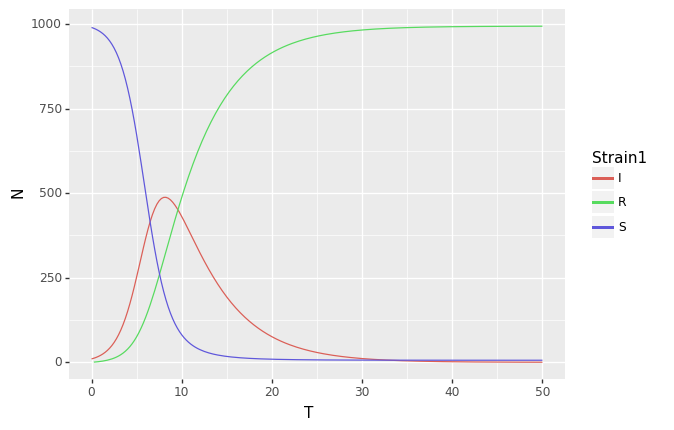

<ggplot: (8732736852674)>

In [7]:
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line

(
    ggplot(SIR.full_epi) +
        aes(x="T", y="N", color="Strain1") +
        geom_line()
)

Things appear to be basically working here. Now as a proof of concept, let's see how easy it is to make an MSEIR model. 

In [8]:
# Make and MSEIR model.

## First let's set up a population of 10000
mseir_pop = pd.DataFrame(
    {
        "InfState": pd.Categorical(['M','S','I'], categories=['M','S','E','I','R']),
        "N": np.array([100, 9899,1]),
        "T":0
    }
)

## We do not have a rule type for birth/death, so let's make our first demographic rule.
class BirthDeath(Rule):
    """! Rule for a simple birth death process. People are assumed to die from all
    rows. The compartment folks come into is specified. Number of births is assumed to
    be based onf the full population size.
    """

    def __init__(self, rate: float, start_state_sig:pd.DataFrame) -> None:
        """! Initialize class
        @param rate the birth and death rate.
        @param start_state_sig state profile. A dummy dataframe with one row and the amount of birth
        """
        super().__init__()
        self.rate = rate
        self.start_state_sig = start_state_sig

    def get_deltas(self, current_state, dt=1.0):
        N = current_state['N'].sum()
        deltas = current_state.assign(N=-current_state['N']*self.rate) #deaths
        births = self.start_state_sig.assign(N=N*self.rate)
        return pd.concat([deltas, births])



test_bd = BirthDeath(34/(1000*365.25), pd.DataFrame(
    {
        "InfState": ['M'],
        "N": 0,
        "T":0
    }
))

##Now put it all together in an EpiModel...measles like.
MSEIR = EpiModel(mseir_pop,
                 rules=[
                    test_bd,
                    SimpleInfection(beta=12/4/10000,column="InfState", i_st="I", inf_to="E"), #R0 is 12
                    SimpleTransition(column="InfState", from_st="E", to_st="I", rate=1/12),#12 day latent period
                    SimpleTransition(column="InfState", from_st="I", to_st="R", rate=1/4 ), #4 day infectious period
                    SimpleTransition(column="InfState", from_st="M", to_st="S", rate=1/(365/2)) #Maternal protection last 6 months. 
                 ])


##let's simulate 10 years
for t in range(365*10):
    MSEIR.do_timestep()




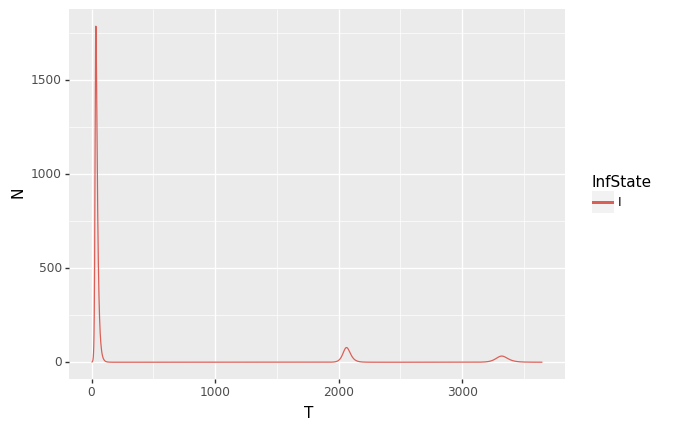

<ggplot: (8732736745310)>

In [9]:
#And plot it
(
    ggplot(MSEIR.full_epi[MSEIR.full_epi['InfState'].isin(["I"])]) +
        aes(x="T", y="N", color="InfState") +
        geom_line()
)

Ok. We have enough together that we can fairly rapildy prototype simple models. But how about some of the more complex things that we might want to look at and performance in a stochastic modeling framework? Let's look at these in turn. Proposed order of extension:
1. Stochastic transition rules.
2. Multi-strain model with partial cross immunity.
    - Or dengue like dynamics.
3. Observation process tracking/logging and clinical outcomes. 
4. Simultaneous demographic processes.
5. Structured population (households, spatial populations)
    - household
    - spatial/age
6. Operational tracking. 
7. Parsing of rules and models from YAML


## Stochastic Transition Rules

Let's redifine the two primary classes we specified so far so that they can have stochastic and non-stochastic versions.

*Question*: Where should stochasticity be defined? At rule constuction or in the calls to get_deltas? If the latter, should it be a property of the epi model? I tend to like the get_deltas and property of the epi-model as mixing of stochastic and non-stochastic transmission rules can lead to errors as stochastic transmission rules will throw errors if they encounter partial people.

In [10]:
## First let's redifine Rule to require a stochastic flag. 
# Note that someone could just throw an error if they do not support stochastic 
# version (or vice-versa)

class Rule(ABC):
    @abstractclassmethod

    def get_deltas(self, current_state, dt:float, stocastic = False):
        """! Method should take in current state and return a 
        series of deltas to that state

        @param current_state a data frame (at the moment) w/ the current epidemic state
        @param dt the size of the timestep

        @return deltas to the epidemic state. 
        """

        pass



## Now a simple independent transition.
class SimpleTransition(Rule):
    """! Class is going to represent a simple transition from one state to another, 
    such that if a column has the from specified value it creates transitions with the to
    specified value at the given rate."""

    def __init__(self, column, from_st, to_st, rate:float) -> None:
        """! Initialization.

        @param column the name of the column this should be applied to.
        @param from_st the state that column should have if this is going to be applied.
        @param to_st the state folks should move to
        """

        super().__init__()
        self.column = column
        self.from_st = from_st
        self.to_st = to_st
        self.rate = rate

    def get_deltas(self, current_state,dt=1.0, stochastic = False):
        deltas = current_state.loc[current_state[self.column]==self.from_st]
        
        if not stochastic:
            #subtractions
            deltas = deltas.assign(
                    N=-deltas.N*(1-np.exp(-dt*self.rate))
                )
        else:
            deltas = deltas.assign(
                N = -np.random.binomial(deltas.N, 1-np.exp(-dt*self.rate))
            )

        #additions
        tmp = deltas.assign(
            N=-deltas.N
        )

        tmp[self.column] = self.to_st

        return pd.concat([deltas, tmp])
    
    def __str__(self) -> str:
        return "{} --> {} at rate {}".format(self.from_st, self.to_st, self.rate)

In [11]:
recover_Strain1 = SimpleTransition('Strain1', 'I', 'R', .2)

recover_Strain1.get_deltas(pop_state, stochastic=True)

,Strain1,Strain2,N,T
1,I,S,-2,0
1,R,S,2,0


In [12]:
#Now our infection rule.
class SimpleInfection(Rule):
    """"! 
    Represents a simple infection process where people in one column are infected by people
    in a given state in that same column with a probability."""

    def __init__(self, beta:float, column, s_st="S", i_st="I", inf_to="I") -> None:
        """!
        Initialize with the columns. 

        @param beta the transmission parameter. 
        @param s_col the column for this infectious process
        @param s_st the state for susceptibles, assumed to be S
        @param i_st the state for infectious, assumed to be I
        @param inf_to the state infectious folks go to, assumed to be I
        """
        super().__init__() 
        self.beta = beta
        self.column = column
        self.s_st = s_st
        self.i_st = i_st
        self.inf_to = inf_to

    def get_deltas(self, current_state, dt = 1.0, stochastic = False):
        infectious = current_state.loc[current_state[self.column]==self.i_st, 'N'].sum()

        deltas = current_state.loc[current_state[self.column]==self.s_st]

        
        #subtractions
        if not stochastic:
            deltas = deltas.assign(
                    N=-deltas.N*(1-np.power(np.exp(-dt*self.beta),infectious))
                )
        else:
            deltas = deltas.assign(
                    N= -np.random.binomial(deltas.N, 1-np.power(np.exp(-dt*self.beta),infectious))
                )
        
        #additions
        tmp = deltas.assign(
            N=-deltas.N
        )

        tmp[self.column] = self.inf_to

        return pd.concat([deltas, tmp])
        
        


simpInf = SimpleInfection(1/1000, "Strain1")
simpInf.get_deltas(pop_state, stochastic=True)


,Strain1,Strain2,N,T
0,S,S,-6,0
0,I,S,6,0


In [13]:
##Now let's modify our epi model to be constructed as either stochastic our deterministic. 
class EpiModel:
    """! Class that that applies a list of rules to a changing current state through 
    some number of time steps to produce an epidemic. It has attributes representing the current
    state and the full epidemic thus far"""

    ##TODO: Add a reset_state method
    ##TODO: Add a precision option when non-stochstic.

    def __init__(self, init_state, rules, stochastic = False) -> None:
        """! Initialize with a initial state and set of rules.
        
        Question: should their be a default for those as NULL
        
        @param init_state the initial state. Must have at minimum columns T and N
        @param rules the initial set of rules
        @param stocastic should this epi model be run stochastically or not."""
        self.cur_state = init_state
        self.full_epi = init_state #the full epidemic is just the current state
        self.rules = rules
        self.stochastic=stochastic
        

    def add_rule(self, rule:Rule) -> None:
        """! add a rule to the list of rules
        @param rule the rule to add"""
        # TODO
        raise ValueError('add_rule has not been implemented')

    def set_state(self, state) -> None:
        """! reset the current state.

        @param state the state to make the current state
        """
        self.cur_state = state
    
    def do_timestep(self, dt=1.0, ret_nw_state= False):
        """! does a timestep, updating the current state and appending to the 
        full epidemic. 
        
        @param dt the time step
        @param ret_nw_state should we return the new state at the end."""

        # Get the deltas for each rule
        all_deltas = pd.DataFrame()
        for rule in self.rules:
            all_deltas = pd.concat([all_deltas,
                                rule.get_deltas(self.cur_state, dt=dt, stochastic=self.stochastic)])
        

        # Now apply the deltas. If the current state is properly clean
        # (i.e., no duplicates) we should just be able to append all deltas
        # to the currents state, group by everything besides N and T and 
        # sum. Need to make sure the T for all deltas is 0 first.
        all_deltas = all_deltas.assign(T=0)


        #append all deltas
        nw_state = pd.concat([self.cur_state, all_deltas])

        # Get grouping columns
        tbr = {'N','T'}
        gp_cols = [item for item in all_deltas.columns if item not in tbr]

        #now collapse
        nw_state = nw_state.groupby(gp_cols,observed=True).sum().reset_index()
        
        nw_state = nw_state.assign(T=max(nw_state['T'])+dt) ##max deals with new states.


        nw_state = nw_state[nw_state['N']!=0]

        self.cur_state = nw_state

        # append the new current state to the epidemic history.
        self.full_epi = pd.concat([self.full_epi, self.cur_state])
        
    

        if ret_nw_state:
            return nw_state


## Do a simple test.
SIR = EpiModel(pop_state, 
               [recover_Strain1,
                simpInf],
                stochastic=True)

SIR.do_timestep()

print(SIR.cur_state)
print(SIR.full_epi)


  Strain1 Strain2    N    T
0       I       S   17  1.0
1       R       S    3  1.0
2       S       S  980  1.0
  Strain1 Strain2    N    T
0       S       S  990  0.0
1       I       S   10  0.0
0       I       S   17  1.0
1       R       S    3  1.0
2       S       S  980  1.0


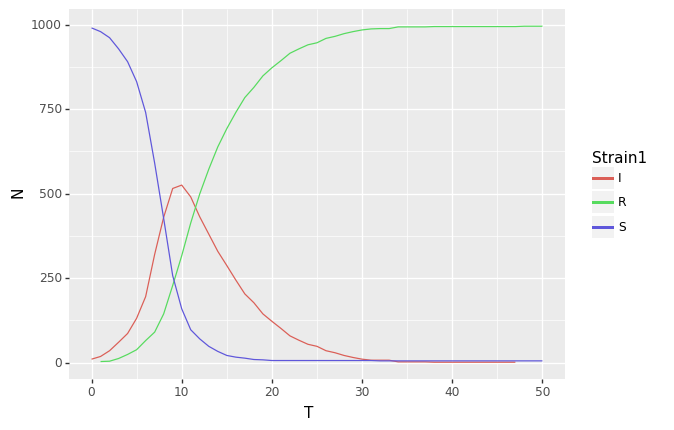

<ggplot: (8732746561852)>

In [14]:
SIR = EpiModel(pop_state, 
               [recover_Strain1,
                simpInf],
                stochastic=True)

for i in range(50):
   SIR.do_timestep(dt=1)

(
    ggplot(SIR.full_epi) +
        aes(x="T", y="N", color="Strain1") +
        geom_line()
)

## Multi-strain Model

Now let's use this framework to define a simple multi strain model with cross protection. The basic idea here is that when we define the infection process for a single column we will define how much protection is gained from immune states in other columns. 

***Note:*** This brings up a challenge with the multi-rule approach. If things can potentially draw for the same state, they need to be in the same rule. In particular, my original implementation here gave problems because someone could be simultaneously infected with two strains, and if we were going to try to apply these independently too many people could be pulled out of a compartment. Hence we need one rule for the multi strain infectios process.

In [15]:
class SimpleMultiStrainInfectiousProcess(Rule):
    """! Simple multi strain infectious process. Takes a cross protection matrix, a list of infection state 
    columns and an array of betas."""
    
    def __init__(self, betas: np.array, columns, cross_protect:np.array, s_st="S", i_st="I",  r_st="R", inf_to="I") -> None:
        """!
        Initialize with the columns. 

        @param betas a beta for each strain
        @param columns the colums for the infection process. Should be same length and order as betas
        @param cross_protect a N(strain)XN(strain) matrix of cross protections.
        @param s_st the state for susceptibles, assumed to be S
        @param i_st the state for infectious, assumed to be I
        @param r_st the state for immune/recovered, assumed to be R
        @param inf_to the state infectious folks go to, assumed to be I
        """
        super().__init__() 
        self.betas = betas
        self.columns = columns
        self.cross_protect = cross_protect
        self.s_st = s_st
        self.i_st = i_st
        self.r_st = r_st
        self.inf_to = inf_to

    def get_deltas(self, current_state, dt = 1.0, stochastic = False):
        
        ##gat number infectious of each type
        infectious = ((current_state[self.columns] == self.i_st).multiply(current_state.N, axis=0)).sum(axis=0)
        infectious = np.array(infectious)

        if sum(infectious)==0:
            return None
        
        ##calculate the strain specific FOI for each row for each strain.

        #first get the cross protections
        row_beta_mult = 1-current_state[self.columns].apply(
            lambda x: ((x==self.r_st).array * self.cross_protect).max(axis=1),
            axis=1,
            result_type='expand'
            )
        
        #now we turn that into a strain specific probablity of infection

        ## This line does a few things:
        #   - it calculates cros protection
        #   - it makes the FOI 0 for folks when folks are not susceptible to a strain
        
        row_beta = (row_beta_mult * self.betas *
                     (current_state[self.columns]==self.s_st).values)
        
        # This makes the probablity of infectoin 0 when folks are infected with a different strain...
        # i.e., no coinfections!
        row_beta = row_beta.multiply(
                1-(current_state[self.columns] == self.i_st).sum(axis=1), axis=0
            )
        prI = 1-(np.exp(-dt*row_beta)).apply(lambda x: np.power(x, infectious), axis=1)

        #deltas can only happen to rows where we have and FOI>1
        deltas =  current_state.loc[prI.sum(axis=1)>0] 
        prI = prI.loc[prI.sum(axis=1)>0] 
        prI.columns = self.columns ##Makes some later stuff easier
        
        ## now do the infectious process.
        if not stochastic:
            #first the subtractions
            deltas = deltas.assign(
                N= -deltas.N*(1 - (1-prI).product(axis=1))
            )

            #now allocate those cases prportional to prI
            tmp = pd.DataFrame()
            for col in self.columns:
                tmp2 = deltas.assign(
                        N=-deltas['N'] * (prI[col]/prI.sum(axis=1)))
                
                tmp2[col] = self.inf_to

                tmp = pd.concat([
                    tmp, 
                    tmp2
                ])
                
            deltas = pd.concat([deltas, tmp])
            
        else:

            Nind = deltas.columns.get_loc('N')
            #multinomial draw for each delta and create the appropriate deltas.
            for i in range(prI.shape[0]):
                #print("here")
                #print(i)
                #print(deltas)
                tmp = np.random.multinomial(deltas['N'].iloc[i], np.append(prI.iloc[i].values,[0]))
                #print("here2")
                deltas.iloc[i,Nind] = -tmp[:-1].sum()
                ##do the additions
                for j in range(prI.shape[1]):
                    toadd = deltas.iloc[[i]]
                    toadd = toadd.assign(N=tmp[j])
                    toadd[self.columns[j]] = self.inf_to
                    deltas = pd.concat([deltas, toadd])
                

        
        deltas = deltas[deltas['N']!=0]

        return deltas
    
cp_matrix = np.array([[1,.5],
                      [.5,1]])
Inf_Strain = SimpleMultiStrainInfectiousProcess(
    np.array([0.5/1000,0.5/1000]),
    ["Strain1", "Strain2"],
    cp_matrix)


##simple test of rule with a lot of cases for I
rc = Inf_Strain.get_deltas(pd.DataFrame(
    {
        'Strain1':["S","S","R","I","S"],
        'Strain2':["S","R","S","S","I"],
        'N':[330,330,325,10,5],
        'T':0
    }
), stochastic=True)

print(rc)
print(rc['N'].sum())



  Strain1 Strain2  N  T
0       S       S -2  0
2       R       S -1  0
0       I       S  1  0
0       S       I  1  0
2       R       I  1  0
0


   Strain1 Strain2    N      T
0        S       S  990   0.00
1        I       S   10   0.00
0        I       S   12   0.25
2        S       S  988   0.25
0        I       S   12   0.50
..     ...     ...  ...    ...
1        R       S  871  49.75
2        S       S  121  49.75
0        I       S    8  50.00
1        R       S  871  50.00
2        S       S  121  50.00

[601 rows x 4 columns]


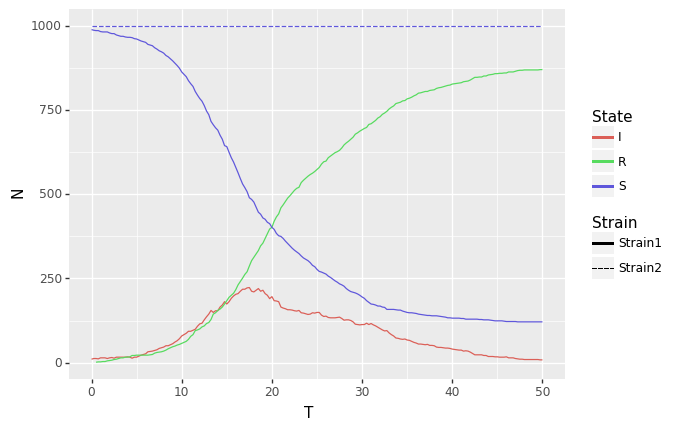

<ggplot: (8732736584245)>

In [16]:
SIR_2Strain = EpiModel(pop_state,
                       rules = [Inf_Strain,
                                SimpleTransition('Strain1','I','R',.2),#strain1 recovery process
                                SimpleTransition('Strain2','I','R',.2)#strain2 recovery process
                                ], stochastic=True)

##first just run like we did before
for i in range(200):
   SIR_2Strain.do_timestep(dt=.25)

print(SIR_2Strain.full_epi)

long_epi = SIR_2Strain.full_epi.melt(id_vars=['N','T'], var_name="Strain", value_name="State")
long_epi = long_epi.groupby(["T","Strain","State"]).sum().reset_index()

(
    ggplot(long_epi) +
        aes(x="T", y="N", color="State", linetype="Strain") +
        geom_line()
)


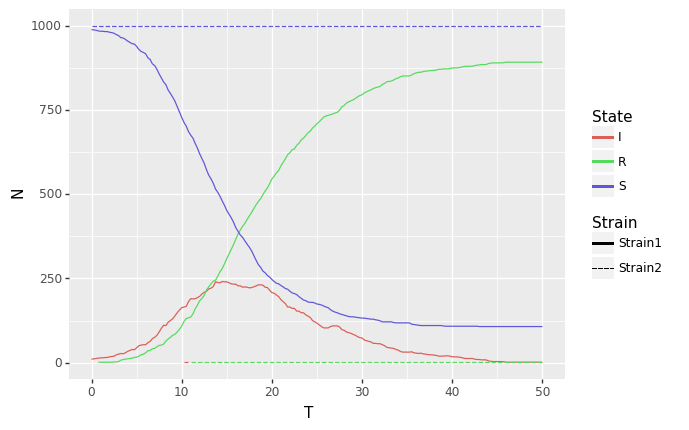

<ggplot: (8732736583741)>

In [17]:


SIR_2Strain = EpiModel(pop_state,
                       rules = [SimpleMultiStrainInfectiousProcess(
                                 np.array([0.5/1000,1/1000]),
                                 ["Strain1", "Strain2"],
                                 cp_matrix),
                                SimpleTransition('Strain1','I','R',.2),#strain1 recovery process
                                SimpleTransition('Strain2','I','R',.2)#strain2 recovery process
                                ], stochastic=True)

## Now run adding an additoinal strain.
##This time let's have the second strain come in late.
intro_day = 10
for i in range(200):
   SIR_2Strain.do_timestep(dt=.25)
   ##when we are on day intro day let's introduce a person who is infectious with strain 2 into the
   ##populatoin. There are more elegant ways to do this with rules, but we are just going
   ##to add it directly.
   
   if SIR_2Strain.cur_state.iloc[0]['T']==intro_day:
      to_add = pd.DataFrame({
         'Strain1':['S'],
         'Strain2':['I'],
         'N':1,
         'T':intro_day
      })
      SIR_2Strain.cur_state = pd.concat([SIR_2Strain.cur_state, to_add])


long_epi = SIR_2Strain.full_epi.melt(id_vars=['N','T'], var_name="Strain", value_name="State")
long_epi = long_epi.groupby(["T","Strain","State"]).sum().reset_index()

(
    ggplot(long_epi) +
        aes(x="T", y="N", color="State", linetype="Strain") +
        geom_line()
)

One more multi-strain model with corss protectoin, just for fun (and testing). This time three strains with the cross protection matrix:
$$
\begin{bmatrix}
1&.5&.2\\
.5&1&.5\\
.2&.5&1
\end{bmatrix}
$$


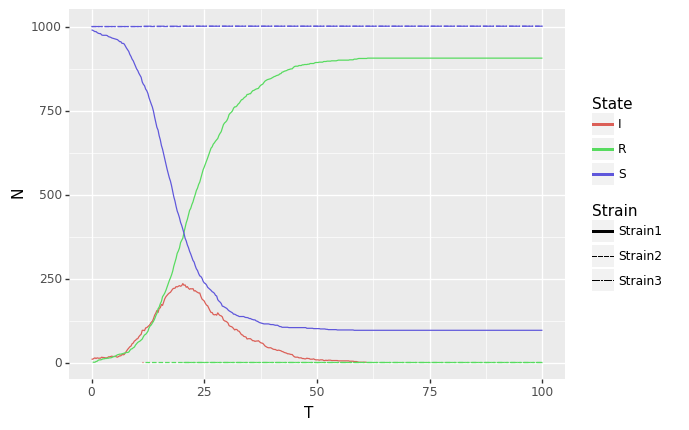

<ggplot: (8732736585542)>

In [18]:
##Three strain version.
## Population
pop_state_3strain = pd.DataFrame(
    {
        "Strain1": pd.Categorical(['S','I'], categories=['S','I','R']),
        "Strain2": pd.Categorical(['S','S'], categories=['S','I','R']),
        "Strain3": pd.Categorical(['S','S'], categories=['S','I','R']),
        "N": np.array([990,10]),
        "T":0
    }
)


##Cross protection matrix.
cp_matrix = np.array([[1,.5,.2],
               [.5,1,.5],
               [.2,.5,1]])

SIR_3Strain = EpiModel(pop_state_3strain,rules=[
                        SimpleMultiStrainInfectiousProcess(betas=np.array([.5/1000,.75/1000,1/1000]),
                                                           columns=['Strain1','Strain2','Strain3'],
                                                           cross_protect=cp_matrix),
                        SimpleTransition('Strain1','I','R',.2),#strain1 recovery process
                        SimpleTransition('Strain2','I','R',.2),#strain2 recovery process
                        SimpleTransition('Strain3','I','R',.2)#strain2 recovery process
                        ],                  
                       stochastic=True)

##This time let's have the second strain come in late.
intro_day1 = 11
intro_day2 = 20.0
for i in range(400):
    SIR_3Strain.do_timestep(dt=.25)
   ##when we are on day intro day let's introduce a person who is infectious with strain 2 into the
   ##populatoin. There are more elegant ways to do this with rules, but we are just going
   ##to add it directly.
    
    if SIR_3Strain.cur_state['T'].values[0]==intro_day1: #weird to me you have to use values
        to_add = pd.DataFrame({
            'Strain1':['S'],
            'Strain2':['I'],
            'Strain3':['S'],
            'N':1,
            'T':[intro_day1]
         })
        SIR_3Strain.cur_state = pd.concat([SIR_3Strain.cur_state, to_add])
    elif (SIR_3Strain.cur_state['T'].values[0]==intro_day2):
        to_add = pd.DataFrame({
            'Strain1':['S'],
            'Strain2':['S'],
            'Strain3':['I'],
            'N':1,
            'T':intro_day2
         })
        SIR_3Strain.cur_state = pd.concat([SIR_3Strain.cur_state, to_add])
       
      
      
long_epi = SIR_3Strain.full_epi.melt(id_vars=['N','T'], var_name="Strain", value_name="State")
long_epi = long_epi.groupby(["T","Strain","State"]).sum().reset_index()

(
    ggplot(long_epi) +
        aes(x="T", y="N", color="State", linetype="Strain") +
        geom_line()
)


## Observation Process Tracking

Here we want to add in an observation process. There are essentially two ways to do this:
1. Have the observation process be soemthing that occurs from some people in established states.
2. Have the observation process occur as part of a rule, occuring for some part of folks in that state.


In either case, we essentially create a new column that caputures the obsreved status. The meaning of this could be super flexible.
Here we take the approach of having three states, **U**nubserved, **I**ncidently observed and **P**reviously observed.

### Established States

In [19]:
class SimpleObservationProcess(Rule):
    '''! This rule captures a simple generic observation process where people from a particular state are
    observed to move into another state at some constant rate.'''

    def __init__(self, source_col, source_state, obs_col, rate:float,  unobs_state="U", incobs_state="I", prevobs_state="P") -> None:
        super().__init__()
        self.source_col = source_col
        self.source_state = source_state
        self.obs_col = obs_col
        self.rate = rate
        self.unobs_state = unobs_state
        self.incobs_state = incobs_state
        self.prevobs_state = prevobs_state

    def get_deltas(self, current_state, dt = 1.0, stochastic = False):
        ##first get the states that produce incident observations
        delta_incobs = current_state.loc[(current_state[self.source_col]==self.source_state) & (current_state[self.obs_col]==self.unobs_state)]

        if not stochastic:
            #subtractions
            delta_incobs = delta_incobs.assign(
                N=-delta_incobs.N*(1-np.exp(-dt*self.rate))
                )
        else:
            delta_incobs = delta_incobs.assign(
                N = -np.random.binomial(delta_incobs.N, 1-np.exp(-dt*self.rate))
            )



        #additions
        tmp = delta_incobs.assign(
            N=-delta_incobs.N
        )

        tmp[self.obs_col] = self.incobs_state

        #move folks out of the incident state
        ##this seems alittle dubm
        delta_toprev = current_state.loc[current_state[self.obs_col]==self.incobs_state].copy()
        tmp2 = delta_toprev.assign(N=-delta_toprev.N)
        delta_toprev[self.obs_col] = self.prevobs_state

        return(pd.concat([delta_incobs, tmp, delta_toprev, tmp2]))



##Population for this test
## For this first pass we will just four collumns, Strain1, Strain2, N and T
pop_state_hosp = pd.DataFrame(
    {
        "DisState": pd.Categorical(['S','I','I'], categories=['S','I','R']),
        "hosp":  pd.Categorical(['U','U','I'], categories=['U','I','P']),
        "N": np.array([980,10,10]),
        "T":0
    }
)


hosp_process = SimpleObservationProcess("DisState", "I", "hosp", 0.1)

print(pop_state_hosp)
hosp_process.get_deltas(pop_state_hosp, stochastic=False)




  DisState hosp    N  T
0        S    U  980  0
1        I    U   10  0
2        I    I   10  0


,DisState,hosp,N,T
1,I,U,-0.951626,0
1,I,I,0.951626,0
2,I,P,10.000000,0
2,I,I,-10.000000,0


Thinking about this rule makes it clear that we need some generic way(s) to deal with multiple rules taking people out of the same state, thereby
overly draining that state compared to what it should, not just messing up dynamics but also creating potential for negative numbers. There are 
a few ways to deal with this:
1. Allow grouping of rules so independent rules are only applied after previous rules have been applied.
    - the easiest to implement.
    - may be other reasons we would want this.
    - allows the user to mess up and is not super general.
2. Applying a solver to the deltas.
    - elegant
    - maximally general
    - does not allow stochasticity without doing something clever
3. Somehow analyzing the rules together to dealt with overlap.
    - Not sure how to do this.

For now we will implement approach one. Might be nice to have the option of approach two for non-stochastic models. Approach three might be best if we can figure out how to do it. 


In [397]:
##Reimplementation of EpiModel with optional rule grouping

class EpiModel:
    """! Class that that applies a list of rules to a changing current state through 
    some number of time steps to produce an epidemic. It has attributes representing the current
    state and the full epidemic thus far"""

    ##TODO: Add a reset_state method
    ##TODO: Add a precision option when non-stochstic.

    def __init__(self, init_state, rules:list, stochastic = False, ) -> None:
        """! Initialize with a initial state and set of rules.
        
        Question: should their be a default for those as NULL
        
        @param init_state the initial state. Must have at minimum columns T and N
        @param rules the initial set of rules. Can either be a list of list of lists.
        @param stocastic should this epi model be run stochastically or not."""
        self.cur_state = init_state
        self.full_epi = init_state #the full epidemic is just the current state

        if isinstance(rules[0],list):
            self.rules = rules
        else:
            self.rules = [rules]
            
        self.stochastic=stochastic
        

    def add_rule(self, rule:Rule) -> None:
        """! add a rule to the list of rules
        @param rule the rule to add"""
        # TODO
        raise ValueError('add_rule has not been implemented')

    def set_state(self, state) -> None:
        """! reset the current state.

        @param state the state to make the current state
        """
        self.cur_state = state
    
    def do_timestep(self, dt=1.0, ret_nw_state= False):
        """! does a timestep, updating the current state and appending to the 
        full epidemic. 
        
        @param dt the time step
        @param ret_nw_state should we return the new state at the end."""

        # interate through the rule sets updating the current state (except for time) after
        #each set of rules to be fed into the next one.
        
        for ruleset in self.rules:
            all_deltas = pd.DataFrame()
            for rule in ruleset:
                all_deltas = pd.concat([all_deltas,
                                    rule.get_deltas(self.cur_state, dt=dt, stochastic=self.stochastic)])
                
            if all_deltas.shape[0]==0:
                continue
            # Now apply the deltas. If the current state is properly clean
            # (i.e., no duplicates) we should just be able to append all deltas
            # to the currents state, group by everything besides N and T and 
            # sum. Need to make sure the T for all deltas is 0 first.
            all_deltas = all_deltas.assign(T=0)

            #append all deltas
            nw_state = pd.concat([self.cur_state, all_deltas])

            # Get grouping columns
            tbr = {'N','T'}
            gp_cols = [item for item in all_deltas.columns if item not in tbr]

            #now collapse..only if we have groups
            if gp_cols:
                nw_state = nw_state.groupby(gp_cols,observed=True).sum().reset_index()

     
            nw_state = nw_state[nw_state['N']!=0]
  

            self.cur_state = nw_state
  
        self.cur_state = self.cur_state.assign(T=max(nw_state['T'])+dt) ##max deals with new states.


        

        

        # append the new current state to the epidemic history.
        self.full_epi = pd.concat([self.full_epi, self.cur_state])
        
    

        if ret_nw_state:
            return self.cur_state



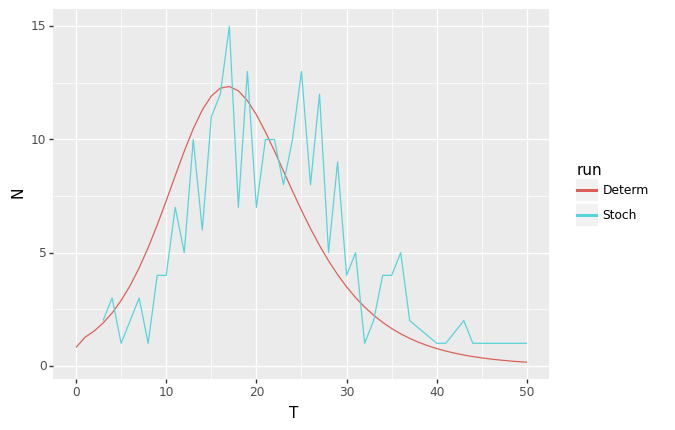

<ggplot: (8732736563759)>

In [21]:


HospTrackSIR = EpiModel(pop_state_hosp[:-1],
                        [[SimpleInfection(.5/1000, "DisState"),
                         SimpleTransition("DisState","I","R",.25)],
                         [hosp_process]], stochastic=False)



HospTrackSIR2 = EpiModel(pop_state_hosp[:-1],
                        [[SimpleInfection(.5/1000, "DisState"),
                         SimpleTransition("DisState","I","R",.25)],
                         [hosp_process]], stochastic=True)


for i in range(203):
    HospTrackSIR.do_timestep(dt=.25)
    HospTrackSIR2.do_timestep(dt=.25)

#print(HospTrackSIR.full_epi.head(20))

#plot hospitalizatoin states by day
inc_hosp = HospTrackSIR.full_epi[["T","N","hosp"]]
inc_hosp = inc_hosp.assign(T=np.floor(inc_hosp["T"]))
inc_hosp = inc_hosp.groupby(["T","hosp"]).sum().reset_index()
inc_hosp1 = inc_hosp.assign(run="Determ")

inc_hosp = HospTrackSIR2.full_epi[["T","N","hosp"]]
inc_hosp = inc_hosp.assign(T=np.floor(inc_hosp["T"]))
inc_hosp = inc_hosp.groupby(["T","hosp"]).sum().reset_index()
inc_hosp = inc_hosp.assign(run="Stoch")
inc_hosp = pd.concat([inc_hosp1, inc_hosp])

(
    ggplot(inc_hosp.loc[inc_hosp["hosp"]=="I"]) +
        aes(x="T", y="N", color="run") +
        geom_line()
)

In [22]:
## Just a little profiling. Definitely need ot com ebakc to making things faster.

HospTrackSIR2 = EpiModel(pop_state_hosp[:-1],
                        [[SimpleInfection(.5/1000, "DisState"),
                         SimpleTransition("DisState","I","R",.25)],
                         [hosp_process]], stochastic=True)

def lp_fun():
    for i in range(203):
        HospTrackSIR2.do_timestep(dt=.25)


%prun lp_fun()


         5011212 function calls (4915462 primitive calls) in 3.962 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
881093/868264    0.153    0.000    0.261    0.000 {built-in method builtins.isinstance}
     3654    0.071    0.000    0.118    0.000 concat.py:278(_get_mgr_concatenation_plan)
6699/5481    0.069    0.000    0.369    0.000 base.py:430(__new__)
342039/268910    0.062    0.000    0.098    0.000 {built-in method builtins.len}
31521/24601    0.060    0.000    0.165    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     6087    0.055    0.000    0.089    0.000 {pandas._libs.lib.maybe_convert_objects}
    13804    0.052    0.000    0.098    0.000 generic.py:5844(__finalize__)
   142903    0.045    0.000    0.104    0.000 generic.py:45(_instancecheck)
     2842    0.043    0.000    0.130    0.000 managers.py:1183(iset)
   142903    0.041    0.000    0.057    0.000 generic.py:40(_check)
 

### Existing Transition with Observation

Here showing how we can extend a rule to capture an observation process, in this case some set of observed infections.

In [23]:
##New rule extending simple infectoin
class ObsInfectionProcess(SimpleInfection):
    '''! Extends the simple infection rule to log cases, etc. Note that this should be paired with 
         a simple that moves folks to a previously observed state prior to the time step.'''
    def __init__(self, beta: float, column, obs_col, obs_rate,
                 s_st="S", i_st="I", inf_to="I",
                 unobs_state="U", incobs_state="I") -> None:
        super().__init__(beta, column, s_st, i_st, inf_to)

        self.obs_col = obs_col
        self.obs_rate = obs_rate
        self.unbs_state = unobs_state
        self.incobs_state = incobs_state


    def get_deltas(self, current_state, dt=1, stochastic=False):
        trans_deltas = super().get_deltas(current_state, dt, stochastic)

        ##allocate trans_deltas appropriately
        if not stochastic:
            tmp = trans_deltas.loc[trans_deltas['N']>0]
            tmp = tmp.assign(N=tmp['N']*self.obs_rate)
            tmp[self.obs_col] = self.incobs_state
            trans_deltas.loc[trans_deltas['N']>0, 'N'] = trans_deltas.loc[trans_deltas['N']>0, 'N'] * (1-self.obs_rate)
            trans_deltas = pd.concat([trans_deltas,tmp])

        else:
            tmp = trans_deltas.loc[trans_deltas['N']>0]
            tmp = tmp.assign(N=np.random.binomial(tmp['N'], self.obs_rate))
            tmp[self.obs_col] = self.incobs_state
            trans_deltas.loc[trans_deltas['N']>0, 'N'] = trans_deltas.loc[trans_deltas['N']>0, 'N'] - tmp['N']
            trans_deltas = pd.concat([trans_deltas,tmp])
        

        return(trans_deltas)
    


ct_pop_state = pop_state.assign(inc_obs="U")

simpObsInf = ObsInfectionProcess(1/1000, "Strain1", "inc_obs",
                                 .75)
simpObsInf.get_deltas(ct_pop_state, stochastic=True)


,Strain1,Strain2,N,T,inc_obs
0,S,S,-10,0,U
0,I,S,1,0,U
0,I,S,9,0,I


In [24]:
class StateCleaner(Rule):
    '''! Simple class that can be used to clean out certain state values ignoring the
    time element.'''
    
    def __init__(self,column, from_st, to_st) -> None:
        self.column = column
        self.from_st = from_st
        self.to_st = to_st

    def get_deltas(self, current_state, dt=1, stochastic=False):
        deltas = current_state.loc[current_state[self.column]==self.from_st].copy()
        tmp = deltas.assign(N = -deltas['N'])
        deltas[self.column] = self.to_st
        return pd.concat([deltas, tmp])



StateCleaner("inc_obs","U","P").get_deltas(ct_pop_state)
  

,Strain1,Strain2,N,T,inc_obs
0,S,S,990,0,P
1,I,S,10,0,P
0,S,S,-990,0,U
1,I,S,-10,0,U


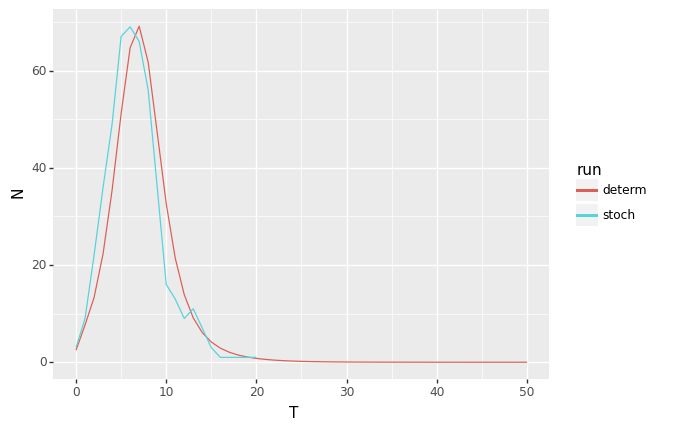

<ggplot: (8732736732299)>

In [25]:
simpObsInf.obs_rate=.5

ObsSIR = EpiModel(ct_pop_state,
                  [[StateCleaner("inc_obs","I","P")],
                   [simpObsInf,
                    SimpleTransition("Strain1","I","R",1/3)]],
                    stochastic=False)

ObsSIR_stoch = EpiModel(ct_pop_state,
                  [[StateCleaner("inc_obs","I","P")],
                   [simpObsInf,
                    SimpleTransition("Strain1","I","R",1/3)]],
                    stochastic=True)



for i in range(101):
    ObsSIR.do_timestep(dt=.5)
    ObsSIR_stoch.do_timestep(dt=.5)



ObsSIR.cur_state


#plot incidtent infections
inc_epi= ObsSIR.full_epi[["T","N","inc_obs"]]
inc_epi = inc_epi.assign(T=np.floor(inc_epi["T"]))
inc_epi = inc_epi.groupby(["T","inc_obs"]).sum().reset_index()
inc_epi = inc_epi.assign(run="determ")

inc_epi2 = ObsSIR_stoch.full_epi[["T","N","inc_obs"]]
inc_epi2 = inc_epi2.assign(T=np.floor(inc_epi2["T"]))
inc_epi2 = inc_epi2.groupby(["T","inc_obs"]).sum().reset_index()
inc_epi2 = inc_epi2.assign(run="stoch")
inc_epi = pd.concat([inc_epi, inc_epi2])


(
    ggplot(inc_epi.loc[inc_epi["inc_obs"]=="I"]) +
        aes(x="T", y="N", color="run") +
        geom_line()
)

## Simultaneous Demographic Process

This one is rather easy given all we have done so far as all we need to do is set up a set of realtively simple transition rules and/or
birth death rules and apply them in their own block.



In [29]:
##For a first pass, let's create a population evenly distributed across 5 year age classes and have it age.
age_struct_pop = pd.DataFrame({
    'DisState' : pd.Categorical(["S"]*15, ["S","I","R"]),
    'AgeCat': ["{} to {}".format(i, i+4) for i in range(0,70,5)]+["70+"],
    'N' : 100
})

#now let's create a list of aging rules.
aging_rules = []

for i in range(0,65,5):
    tmp = SimpleTransition("AgeCat","{} to {}".format(i,i+4), "{} to {}".format(i+5,i+9), 1/(365.25*5))
    aging_rules.append(tmp)

aging_rules.append(SimpleTransition("AgeCat","65 to 69", "70+", 1/(365.25*5)))

##Just to make sure things are working, let's create an EpiModel with only these aging rules.
agingPop = EpiModel(age_struct_pop,
                    aging_rules, stochastic=False)

for i in range(10):
    agingPop.do_timestep(dt=365)

print(agingPop.cur_state)




   DisState    AgeCat           N       T
0         S    0 to 4   13.552067  3650.0
1         S  10 to 14   73.382936  3650.0
2         S  15 to 19   90.992624  3650.0
3         S  20 to 24   97.810430  3650.0
4         S  25 to 29   99.620439  3650.0
5         S  30 to 34   99.954138  3650.0
6         S  35 to 39   99.996324  3650.0
7         S  40 to 44   99.999824  3650.0
8         S  45 to 49   99.999996  3650.0
9         S    5 to 9   43.534061  3650.0
10        S  50 to 54  100.000000  3650.0
11        S  55 to 59  100.000000  3650.0
12        S  60 to 64  100.000000  3650.0
13        S  65 to 69  100.000000  3650.0
14        S       70+  281.157161  3650.0


In [544]:
##Now let's make simple sperate birth and death rules. 

class BirthProcess(Rule):
    """! Rule for a simple birth  process Number of births is assumed to
    be based onf the full population size.
    """

    def __init__(self, rate: float, start_state_sig:pd.DataFrame) -> None:
        """! Initialize class
        @param rate the birth and death rate.
        @param start_state_sig state profile. A dummy dataframe with one row and the amount of birth
        """
        self.rate = rate

        #there are better ways to do this.
        if isinstance(start_state_sig, dict):
            start_state_sig = pd.DataFrame(start_state_sig,index=[0])
           
        self.start_state_sig = start_state_sig

    def get_deltas(self, current_state, dt=1.0, stochastic=False):
        N = current_state['N'].sum()
        if not stochastic:
            births = self.start_state_sig.assign(N=N*(1-np.exp(-dt*self.rate)))
        else:
            births = self.start_state_sig.assign(N=np.random.poisson(N*(1-np.exp(-dt*self.rate))))
        return births


us_like_birth = BirthProcess(7/1000, age_struct_pop.iloc[[0]])

print(us_like_birth.get_deltas(age_struct_pop, stochastic=True))

##death rule 
class SimpleDeathByCat(Rule):
    """! Rule has people die from a particular group at a particular rate. This version can only use one column"""
    def __init__(self, column, state, rate) -> None:
        """!
        @param column the column that specifies what state we are specifying deaths for
        @param state the state we are specifying deaths for
        @param rate the death rate we are specifying this for"""
        self.column = column
        self.state = state
        self.rate = rate

    def get_deltas(self, current_state, dt=1.0, stochastic=False):

        deltas = current_state.loc[current_state[self.column]==self.state]

        if not stochastic:
            deltas = deltas.assign(N=-deltas['N']*(1-np.exp(-dt*self.rate)))
        else:
            deltas = deltas.assign(N=-np.random.binomial(deltas['N'],1-np.exp(-dt*self.rate)))
        
        return deltas

simp_death = SimpleDeathByCat("AgeCat","70+",5000/100000)
print(simp_death.get_deltas(age_struct_pop, stochastic=True))

  DisState  AgeCat  N
0        S  0 to 4  9
   DisState AgeCat  N
14        S    70+ -3


   DisState    AgeCat             N       T
0         I    0 to 9  2.726351e+04  2033.0
1         I  10 to 19  3.220809e+03  2033.0
2         I  20 to 29  3.770954e+02  2033.0
3         I  30 to 39  4.449777e+01  2033.0
4         I  40 to 49  5.247282e+00  2033.0
5         I  50 to 59  6.054221e-01  2033.0
6         I  60 to 69  6.690871e-02  2033.0
7         I       70+  7.409984e-03  2033.0
8         R    0 to 9  2.777267e+06  2033.0
9         R  10 to 19  1.978041e+06  2033.0
10        R  20 to 29  1.506345e+06  2033.0
11        R  30 to 39  1.348864e+06  2033.0
12        R  40 to 49  1.301111e+06  2033.0
13        R  50 to 59  1.286023e+06  2033.0
14        R  60 to 69  1.246536e+06  2033.0
15        R       70+  1.745566e+06  2033.0
16        S    0 to 9  4.995593e+05  2033.0
17        S  10 to 19  5.701253e+04  2033.0
18        S  20 to 29  6.668631e+03  2033.0
19        S  30 to 39  7.868869e+02  2033.0
20        S  40 to 49  9.279150e+01  2033.0
21        S  50 to 59  1.070612e

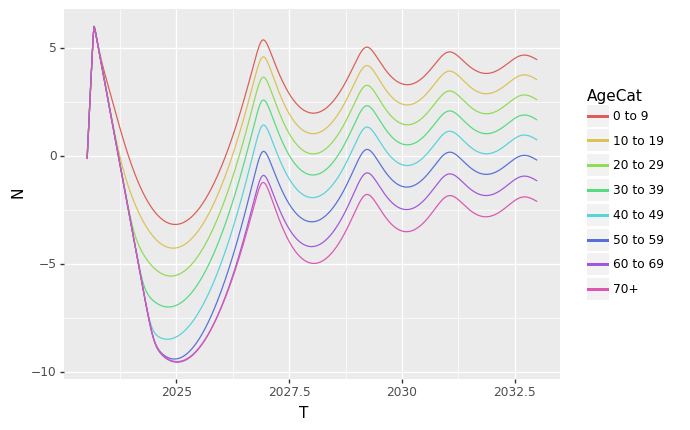

<ggplot: (8732729266056)>

In [105]:
##Now that we have all the stuff we need let's put it together into a single epidemic model in a populatoin that looks like NC
##that sudendly encounters a novel (and uncontrolled) measles like disease.

##First we lay out our population
nc_like_pop = pd.DataFrame({
    'DisState' : pd.Categorical(["S"]*8, ["S","I","R"]),
    'AgeCat': ["{} to {}".format(i, i+9) for i in range(0,70,10)]+["70+"],
    'N' :[1140000, 1320000,1320000,1290000,1280000, 1280000,1185000,1175000],
    'T' : 2023
})


#Aging rules. Let a timestep be a year.
nc_aging_rules=[]
for i in range(0,60,10):
    tmp = SimpleTransition("AgeCat","{} to {}".format(i,i+9), "{} to {}".format(i+10,i+19), 1/10)
    nc_aging_rules.append(tmp)

nc_aging_rules.append(SimpleTransition("AgeCat","60 to 69", "70+", 1/10))#For this one let the timestep be a year.

#Birth process
#nc_birth = BirthProcess(7/1000, nc_like_pop.iloc[[0]])
nc_birth = BirthProcess(38/1000, nc_like_pop.iloc[[0]])

#Death processes
nc_deaths = [
     SimpleDeathByCat("AgeCat", "0 to 9",1.5/1000),
     SimpleDeathByCat("AgeCat","10-19",.1/1000),
     SimpleDeathByCat("AgeCat","20-29",1/1000),
     SimpleDeathByCat("AgeCat","30-39",1.9/1000),
     SimpleDeathByCat("AgeCat","40-49",2.7/1000),
     SimpleDeathByCat("AgeCat","50-59",4.9/1000),
     SimpleDeathByCat("AgeCat","60-69",10.7/1000),
     SimpleDeathByCat("AgeCat","70+",43.9/1000)
 ]


infect = pd.DataFrame({
    "DisState":"I",
    "AgeCat":"10 to 19",
    "N": [1],
    "T": 2023
})

##Epi Model with all of these rules.
NC_demo_epi = EpiModel(pd.concat([nc_like_pop,infect]),
                       [nc_aging_rules,
                        [nc_birth],
                        nc_deaths,
                        [SimpleInfection(12*26/10000000, "DisState"),
                         SimpleTransition("DisState","I","R",26)]],
                         stochastic=False)


for i in range(10*52):
    NC_demo_epi.do_timestep(1/52)

print(NC_demo_epi.cur_state)


tmp = NC_demo_epi.full_epi.loc[NC_demo_epi.full_epi['DisState']=="I"]
tmp = tmp.assign(N=np.log10(tmp['N']))
(
    ggplot(tmp) +
        aes(x="T", y="N", color="AgeCat") +
        geom_line()
)


## Structured Populations

### Households

First we will look at a structured population with households. This will serve to some extent as a performance test as this scales towards and agent based mdoel. I.e., how much does the complexitiy of a relatively small household populatoin (say 1000 people) impact performance. 

In [134]:
##Let's define a transmission rule that has one risk if folks share a characteristic
##like household, and another if folks do not share that characteristic.

class SharedTraitTransmission(Rule):

    def __init__(self,in_beta:float, out_beta:float,
                 inf_col, trait_col, s_st="S", i_st="I",
                 inf_to="I") -> None:
        '''!
        @param in_beta transmission risk if trait shared
        @param out_beta transmission risk if trait not shared
        @param inf_col the column designating infection state
        @param trait_col the column designaing the trait
        @param s_st the suseptible state
        @param i_st the infectoius state
        @param inf_to the state to move infectous folks to'''
        self.in_beta = in_beta
        self.out_beta = out_beta
        self.inf_col = inf_col
        self.trait_col = trait_col
        self.s_st = s_st
        self.i_st = i_st
        self.inf_to = inf_to
        super().__init__()

    def get_deltas(self, current_state, dt = 1.0, stochastic=False):
        ##first let's get folks who are susceptible. These are the states we will actually
        ##see deltas from.
        deltas = current_state.loc[current_state[self.inf_col]==self.s_st].copy()
        deltas_add = deltas.copy()

        #Now loop over folks in this state. 
        #There might be faster ways to do this.
        for ind, row in deltas.iterrows():
            inI = current_state.loc[(current_state[self.trait_col]==row[self.trait_col]) & (current_state[self.inf_col]==self.i_st)].N.sum()
            outI = current_state.loc[(current_state[self.trait_col]!=row[self.trait_col]) & (current_state[self.inf_col]==self.i_st)].N.sum()
            prI = 1-np.power(np.exp(-dt*self.in_beta),inI)*np.power(np.exp(-dt*self.out_beta),outI)

            if not stochastic:
                row['N'] = row['N']*prI
            else:
                row['N'] = np.random.binomial(row['N'],prI)
            deltas.at[ind,'N'] = -row['N']
            deltas_add.at[ind,'N'] = row['N']
        
        deltas_add[self.inf_col] = self.inf_to

        rc = pd.concat([deltas,deltas_add])

        return rc.loc[rc.N!=0]
    
##simple test. 2 HHs
hh_pop = pd.DataFrame({
    'DisState': pd.Categorical(['S','S','I'], categories=['S','I','R']),
    'HH': [1,2,2],
    'N': [3,2,1],
    'T':0
})

simpleHHTrans = SharedTraitTransmission(.2,.002,"DisState","HH")
simpleHHTrans.get_deltas(hh_pop, stochastic=True)


,DisState,HH,N,T
0,S,1,-1,0
0,I,1,1,0


Now that we have a transmission rule let's create a much larger 
population and simulate and epidemic.

In [173]:
##create a population with 500 households of average size 2 and one
##person infected in the 500th household
hh_pop = pd.DataFrame({
    'DisState':pd.Categorical(["S"]*500+["I"],  categories=['S','I','R']),
    'HH': list(range(500))+['499'],
    'N': list(1+np.random.poisson(1,500))+[1],
    'T':0
})


##We have the population, now let's run an epidemic
hhEpi = EpiModel(hh_pop,
                 [SharedTraitTransmission(.05,.0005,"DisState","HH"),
                  SimpleTransition("DisState","I","R",.5)],
                  stochastic=True)

#Note this is a little boring if non-stochastic
for i in range(50):
    hhEpi.do_timestep(dt=1)

hhepi_full = hhEpi.full_epi
hhepi_cur = hhEpi.cur_state

hhepi_cur


,DisState,HH,N,T
0,R,0,1,50
1,R,1,1,50
2,R,2,2,50
3,R,3,1,50
4,R,4,1,50
...,...,...,...,...
675,S,494,1,50
676,S,495,1,50
677,S,496,1,50
678,S,497,1,50


In [145]:
%load_ext rpy2.ipython
%R library(tidyverse)

#set up R and library tidyverse


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



array(['forcats', 'stringr', 'dplyr', 'purrr', 'readr', 'tidyr', 'tibble',
       'ggplot2', 'tidyverse', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

/home/justin/anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
/home/justin/anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "HH". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'int'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


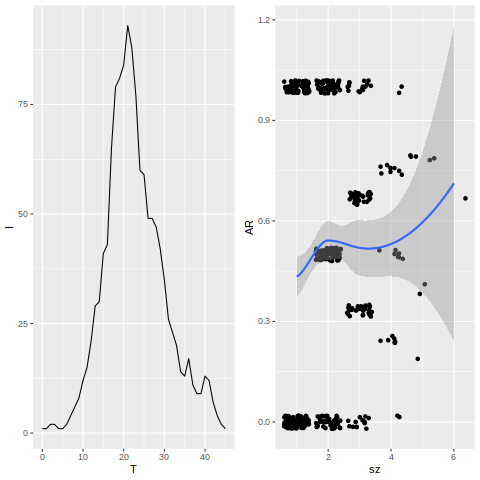

In [176]:
%%R -i hhepi_full,hhepi_cur

library(gridExtra)

#Let's plot the distribution of HH attackrates by HH size and the 
#epi curve. This is a plae where tidyverse and ggplot would be great
#so let's use R
epi_curve <- hhepi_full %>%
    filter(DisState=="I") %>%
    group_by(T) %>%
    summarize(I=sum(N))%>%
    ungroup()

#plot the full epi curve
ec_plot <- epi_curve %>%
    ggplot(aes(x=T, y=I)) + 
      geom_line()



#plot HH attack rates by HH size.
ars <- hhepi_cur%>%group_by(HH)%>%
    summarize(sz=sum(N),
              infs = sum(N[DisState=="R"]),
              AR=infs/sz)%>%
    ungroup()

ar_plot <- ars%>%ggplot(aes(x=sz, y=AR)) +
    geom_jitter() + 
    geom_smooth()

grid.arrange(ec_plot, ar_plot, ncol=2)

### Age/Spatial Stuctured model

Ok. Now let's implement a population structureed model where we have just young kids, school age kids and adults. Their is some assortative mixing
and the disease transmits much more effciently in school age children.

In [328]:
##First we define a mixing matrix based infectious process.

class StructuredTransmission(Rule):
    
    def __init__(self, beta_matrix, inf_col, group_col,
                 s_st="S", i_st="I",inf_to="I") -> None:
        '''! 
        @param beta_matrix matrix of cross betas with row being infector, column being infectee
        @param inf_col the column with the infectiou state
        @param group_col the column that specified group. Number of unique values should match columns of beta matrix
        @param s_st susceptible state
        @param i_st the infectious state
        @param inf_to state folks should move to on infectoin '''
        self.beta_matrix = beta_matrix
        self.inf_col = inf_col
        self.group_col = group_col
        self.s_st = s_st
        self.i_st = i_st
        self.inf_to = inf_to

    def get_deltas(self, current_state, dt = 1.0, stochastic=False):
        ##create an array of the number infectious in each group.
        inf_array = current_state.loc[current_state[self.inf_col]==self.i_st].groupby(self.group_col).sum(numeric_only=True)['N'].values

        ##print(current_state.loc[current_state[self.inf_col]==self.i_st])
        ##print(inf_array)
      
        prI = np.power(np.exp(-dt*self.beta_matrix),inf_array)
        prI = 1-prI.prod(axis=1)


        ##get folks in susceptible states
        deltas = current_state.loc[current_state[self.inf_col]==self.s_st]
        
        ##do infectious process
        if not stochastic:
            deltas = deltas.assign(N=-deltas['N']*prI[deltas[self.group_col].cat.codes])
        else:
            deltas = deltas.assign(N=-np.random.binomial(deltas['N'],prI[deltas[self.group_col].cat.codes]))

        deltas_add = deltas.assign(N=-deltas['N'])
        deltas_add[self.inf_col] = self.inf_to
        
        rc = pd.concat([deltas,deltas_add])
        return rc.loc[rc.N!=0]
    
#it is important to use categorical to make matrix multiplications work well.
three_age_pop = pd.DataFrame({
    'DisState': pd.Categorical(['S','I']*3, ['S','I','R']),
    'AgeGroup':pd.Categorical(["school","school","adult","adult","presch","presch"], ['presch','school','adult']),
    'N': [332,1,331,2,330,0],
    'T':0
})


beta_matrix = np.array([[.2,.05,.1],
                        [.05,.75,.1],
                        [.1,.1,.3]])

ageTrans = StructuredTransmission(beta_matrix/330, 'DisState','AgeGroup')

ageTrans.get_deltas(three_age_pop, stochastic=False)

        

,DisState,AgeGroup,N,T
0,S,school,-0.954383,0
2,S,adult,-0.701377,0
4,S,presch,-0.249905,0
0,I,school,0.954383,0
2,I,adult,0.701377,0
4,I,presch,0.249905,0


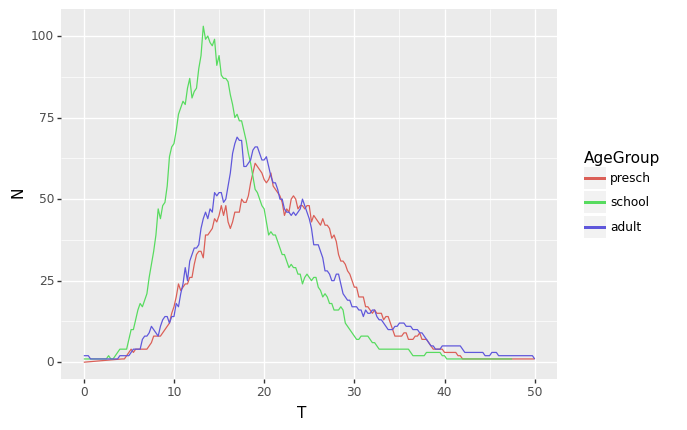

<ggplot: (8732708026353)>

In [333]:
#Now let's run an actual epidemic of this. 
threeAgeEpi = EpiModel(three_age_pop,
                       [ageTrans,
                        SimpleTransition("DisState","I","R",.25)],
                        stochastic=True)

for i in range(200):
    threeAgeEpi.do_timestep(dt=.25)


threeage_epi = threeAgeEpi.full_epi

(
    ggplot(threeage_epi.loc[threeage_epi["DisState"]=="I"]) +
        aes(x="T", y="N", color="AgeGroup") +
        geom_line()
)

## Operational Tracking

This will attempt to show how this method can be used to track vaccination by campaign. We will construct and MSIRV for a virus with measles level tranmissiblity. We will then vaccinate for it with an all or nothing vaccine over multiple rounds, each represented by a vaccine rule, and tracking  for each group which round they got vaccinated in. 

In [406]:
##Rule for vaccination campaign

class InstantaneousVaxCampaign(Rule):
    '''! Rule that triggers a vaccination campaign. For the purposes of this simple example the campaign takes place
    at a discrete moment in time and moves the percent vaccinated to the vaccinated disease state and logs that they revieved the vaccine in 
    the appropriate column'''

    def __init__(self, t, pct_vax, VE, inf_col, camp_col, s_st="S", v_st="V")-> None:
        '''!
        @param t the timing of the vaccination campaign. Must actually occur in out timestep.
        @param pct_vax the percentage of the population to be vaccinated in the campaign
        @param VE the vaccine effiveness.
        @param inf_col the column for the infectious process
        @param camp_col the column that indicates if folks where vaccinated in this campaign. Just true of false.
        @param s_st the susceptible state, only these folks get moved to the vaccinated state
        @param v_st the vaccinated state
        '''
        self.t = t
        self.pct_vax = pct_vax
        self.VE = VE
        self.inf_col = inf_col
        self.camp_col = camp_col
        self.s_st = s_st
        self.v_st = v_st

    def get_deltas(self, current_state, dt=1.0, stochastic=False):
        #If this is not the time, just return
        #print(current_state.iloc[0]['T'])
        if np.abs(current_state.iloc[0]['T']-self.t)>(dt/2):
            return None

        #if this is the time, do the campaign
        deltas = current_state.copy()

        if not stochastic:
            #first give the vaccinations.
            deltas.N = -deltas.N * self.pct_vax
        else:
            deltas.N = -np.random.binomial(deltas.N, self.pct_vax)

        deltas_add = deltas.assign(N=-deltas.N)
        deltas_add[self.camp_col]=True

        #now, we do the successful vaccines
        delta_succcess = deltas_add.loc[deltas_add[self.inf_col]==self.s_st].copy()

        if not stochastic:
            delta_succcess.N = delta_succcess.N * self.VE
        else:
            delta_succcess.N = np.random.binomial(delta_succcess.N, self.VE)

        delta_succcess[self.inf_col] = self.v_st
            
      

        deltas_add.loc[deltas_add[self.inf_col]==self.s_st,'N'] = ( 
            deltas_add.loc[deltas_add[self.inf_col]==self.s_st,'N'] -
                delta_succcess.N
        )

        return pd.concat([deltas, deltas_add, delta_succcess])



mat_immune_pop = pd.DataFrame({
    "DisState":pd.Categorical(['M','S','I'],['M','S','I','R','V']),
    "Camp1":False,
    "Camp2":False,
    "Camp3":False,
    "N":[10000,90000,1],
    "T":0
})

vaxCamp1 = InstantaneousVaxCampaign(5,.7,.9,"DisState","Camp1")

vaxCamp1.get_deltas(mat_immune_pop.assign(T=5), stochastic=True)

,DisState,Camp1,Camp2,Camp3,N,T
0,M,False,False,False,-6990,5
1,S,False,False,False,-62888,5
2,I,False,False,False,-1,5
0,M,True,False,False,6990,5
1,S,True,False,False,6278,5
2,I,True,False,False,1,5
1,V,True,False,False,56610,5


In [349]:
##Need a simple death rule.
class SimpleDeath(Rule):
    """! Simple constant death rate process. 
    """

    def __init__(self, rate: float) -> None:
        """! Initialize class
        @param rate death rate
        """
        self.rate = rate

    def get_deltas(self, current_state, dt=1.0, stochastic=False):
        if not stochastic:
            deltas = current_state.assign(N=-current_state['N']*(1-np.exp(-dt*self.rate))) #deaths
        else:
            deltas = current_state.assign(N=-np.random.binomial(current_state['N'],1-np.exp(-dt*self.rate)))

        return deltas
    

simp_death = SimpleDeath(rate=38/1000)
simp_death.get_deltas(mat_immune_pop, stochastic=True)
    



,DisState,Camp1,Camp2,Camp3,N,T
0,M,False,False,False,-376,0
1,S,False,False,False,-3366,0
2,I,False,False,False,0,0


In [423]:
##Now let's do the epidemic model. Make sure to group
##our campaign stuff, our demographics and our epidemic process
##into discrete sections. We assume t is in years here.

threeCampEpi = EpiModel(mat_immune_pop,
                        [[ InstantaneousVaxCampaign(10,.85,.95,"DisState","Camp1"),  
                           InstantaneousVaxCampaign(15,.85,.95,"DisState","Camp2"),  
                           InstantaneousVaxCampaign(20,.85,.95,"DisState","Camp3")], #campaigns
                         [BirthProcess(38/1000, pd.DataFrame({
                            "DisState":["M"],
                            "Camp1":False,
                            "Camp2":False,
                            "Camp3":False,
                            "N":0,
                            "T":0
                         })), SimpleDeath(38/1000)], #demographic rule
                         [SimpleInfection(12*26/100000, column="DisState"),
                          SimpleTransition("DisState","I","R",26),
                          SimpleTransition("DisState","M","S",12/9)] #epidemic rules.
                         ], stochastic=False)



for i in range(52*25):
    threeCampEpi.do_timestep(dt=1/52)


threeCampEpi_res = threeCampEpi.full_epi


/home/justin/anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame


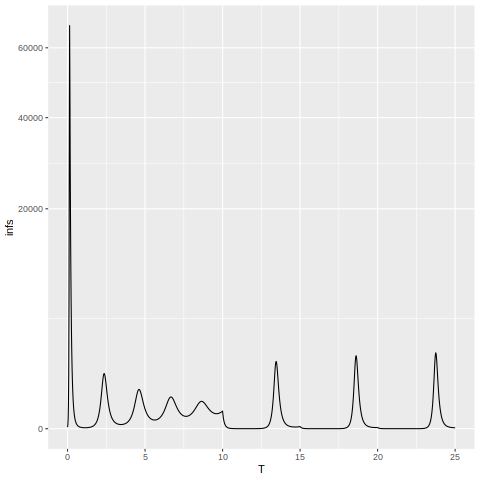

In [424]:
%%R -i threeCampEpi_res

threeCampEpi_res%>%
    filter(DisState=="I") %>%
    group_by(T)%>%
    summarize(infs=sum(N))%>%
    ungroup()%>%
    ggplot(aes(x=T,y=infs))+
        geom_line()+
        scale_y_sqrt()

In [429]:
%%R
##Create a crosstab of the number of vaccine status and attack rates.

max_t <-max(threeCampEpi_res$T)

AR_profiles <- threeCampEpi_res%>%
    filter(T==max_t)%>%
    group_by(Camp1,Camp2,Camp3)%>%
    summarize(tot=sum(N),
                AR=sum(N[DisState=="R"])/tot)%>%
    ungroup()

AR_profiles


`summarise()` has grouped output by 'Camp1', 'Camp2'. You can override using
the `.groups` argument.
# A tibble: 8 × 5
  Camp1 Camp2 Camp3    tot    AR
  <lgl> <lgl> <lgl>  <dbl> <dbl>
1 FALSE FALSE FALSE 19908. 0.559
2 FALSE FALSE TRUE  14754. 0.678
3 FALSE TRUE  FALSE  2590. 0.765
4 FALSE TRUE  TRUE  14679. 0.751
5 TRUE  FALSE FALSE  1082. 0.933
6 TRUE  FALSE TRUE   6129. 0.932
7 TRUE  TRUE  FALSE  6129. 0.927
8 TRUE  TRUE  TRUE  34731. 0.927


## Adding Parsing From YAML

The parsing of rules here is super easy, you can just use standard python stuff (at least according to ChatGPT) as in the below example.

In [431]:
%load_ext yamlmagic

In [434]:
%%yaml simp_trans_yaml
rule: SimpleTransition
parameters:
  column: DisStat
  from_st: I
  to_st: R
  rate: .25
    

<IPython.core.display.Javascript object>

In [436]:
recover = globals()[simp_trans_yaml['rule']](**simp_trans_yaml['parameters'])
print(recover)

I --> R at rate 0.25


Ok. That is insanely easy. We can also make rules output themselves as readable yaml. Regardless, next is to specify a full epi model. Let's first define an epi model and then see about reading it in.

In [497]:
%%yaml SIR_yaml
init_state:
  DisState: ['S','I']
  N: [990,10]
  T: 0
rules:
  - rule: SimpleInfection
    parameters: 
      beta: 0.0005
      column: DisState
  - rule: SimpleTransition
    parameters:
      column: DisState
      from_st: I
      to_st: R
      rate: 0.25
stochastic: True
    

<IPython.core.display.Javascript object>

In [491]:
print(SIR_yaml)

{'init_state': {'DisState': ['S', 'I'], 'N': [999, 1], 'T': 0}, 'rules': [{'rule': 'SimpleInfection', 'parameters': {'beta': 0.0005, 'column': 'DisState'}}, {'rule': 'SimpleTransition', 'parameters': {'column': 'DisState', 'from_st': 'I', 'to_st': 'R', 'rate': 0.25}}], 'stochastic': True}


In [524]:
import copy

##Lets add a from yaml classmethod to EpiModel
class EpiModel:
    """! Class that that applies a list of rules to a changing current state through 
    some number of time steps to produce an epidemic. It has attributes representing the current
    state and the full epidemic thus far"""

    ##TODO: Add a reset_state method
    ##TODO: Add a precision option when non-stochstic.
    ##TODO: decide if we want to make it possible to add rules dynamically

    def __init__(self, init_state, rules:list, stochastic = False, ) -> None:
        """! Initialize with a initial state and set of rules.
        
        Question: should their be a default for those as NULL
        
        @param init_state the initial state. Must have at minimum columns T and N
        @param rules the initial set of rules. Can either be a list of list of lists.
        @param stocastic should this epi model be run stochastically or not."""
        self.cur_state = init_state
        self.full_epi = init_state #the full epidemic is just the current state

        if isinstance(rules[0],list):
            self.rules = rules
        else:
            self.rules = [rules]
            
        self.stochastic=stochastic
        

    @classmethod
    def from_yaml(cls, epi_yaml):
        '''! Creates the class from a dictionary object presumed to be read in from a yaml object'''
        #TODO Extend this init state so it could also be read in from a CSV file.
        init_state = pd.DataFrame(epi_yaml['init_state'])

        #Check stochastc, defaulting to false. 
        if 'stochastic' in epi_yaml:
            stochastic = epi_yaml['stochastic']
        else:
            stochastic = False

        #now instantiate rules. Important to work on a copy
        rules = copy.deepcopy(epi_yaml['rules'])

        #make sure rules have nested structure
        if not isinstance(rules[0],list):
            rules = [rules]

        #now iterate over rulesets...turning dicts into rules.
        # TODO a more flexible way of making the rules is to have a from yaml version
        for ruleset in rules:
            for i in range(len(ruleset)):
                ruleset[i] =  globals()[ruleset[i]['rule']](**ruleset[i]['parameters'])

        return cls(init_state, rules, stochastic)
        
        
    
    def do_timestep(self, dt=1.0, ret_nw_state= False):
        """! does a timestep, updating the current state and appending to the 
        full epidemic. 
        
        @param dt the time step
        @param ret_nw_state should we return the new state at the end."""

        # interate through the rule sets updating the current state (except for time) after
        #each set of rules to be fed into the next one.
        
        for ruleset in self.rules:
            all_deltas = pd.DataFrame()
            for rule in ruleset:
                all_deltas = pd.concat([all_deltas,
                                    rule.get_deltas(self.cur_state, dt=dt, stochastic=self.stochastic)])
                
            if all_deltas.shape[0]==0:
                continue
            # Now apply the deltas. If the current state is properly clean
            # (i.e., no duplicates) we should just be able to append all deltas
            # to the currents state, group by everything besides N and T and 
            # sum. Need to make sure the T for all deltas is 0 first.
            all_deltas = all_deltas.assign(T=0)

            #append all deltas
            nw_state = pd.concat([self.cur_state, all_deltas])

            # Get grouping columns
            tbr = {'N','T'}
            gp_cols = [item for item in all_deltas.columns if item not in tbr]

            #now collapse..only if we have groups
            if gp_cols:
                nw_state = nw_state.groupby(gp_cols,observed=True).sum().reset_index()

     
            nw_state = nw_state[nw_state['N']!=0]
  

            self.cur_state = nw_state
  
        self.cur_state = self.cur_state.assign(T=max(nw_state['T'])+dt) ##max deals with new states.

        # append the new current state to the epidemic history.
        self.full_epi = pd.concat([self.full_epi, self.cur_state])
        
        if ret_nw_state:
            return self.cur_state



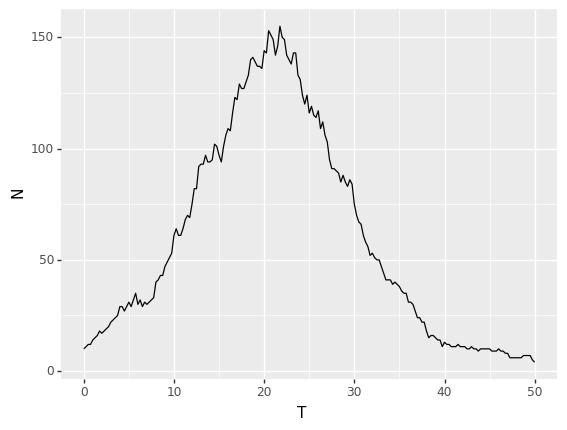

<ggplot: (8732708130222)>

In [498]:
##Test our epi model
SIR_model = EpiModel.from_yaml(SIR_yaml)


for i in range(200):
    SIR_model.do_timestep(dt=.25)

(
    ggplot(SIR_model.full_epi.loc[SIR_model.full_epi['DisState']=="I"]) +
      aes(x="T",y="N")+
      geom_line()
)


Now let's try something a bit more complicated. 

In [576]:
%%yaml MSIR_yaml

init_state:
    DisState: [M,S,I]
    N: [10000,90000,1]
    T: 0
rules:
  -
    - rule: BirthProcess
      parameters:
        rate: .038
        start_state_sig: {DisState: M, N: 0, T: 0}
    - rule: SimpleDeath
      parameters:
        rate: .038
  -
    - rule: SimpleInfection
      parameters: {beta: 0.00312, column: DisState}
    - rule: SimpleTransition
      parameters: {column: DisState, from_st: I, to_st: R, rate: 26}
    - rule: SimpleTransition
      parameters: {column: DisState, from_st: M, to_st: S, rate: 1.33}
      



<IPython.core.display.Javascript object>

In [577]:

MSIR_epi = EpiModel.from_yaml(MSIR_yaml)

for i in range(20*52):
    MSIR_epi.do_timestep(dt=1/52)

MSIR_epi_res = MSIR_epi.full_epi

MSIR_epi.cur_state

,DisState,N,T
0,I,174.065656,20.0
1,M,2742.428855,20.0
2,R,90441.032552,20.0
3,S,6643.472937,20.0


/home/justin/anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame


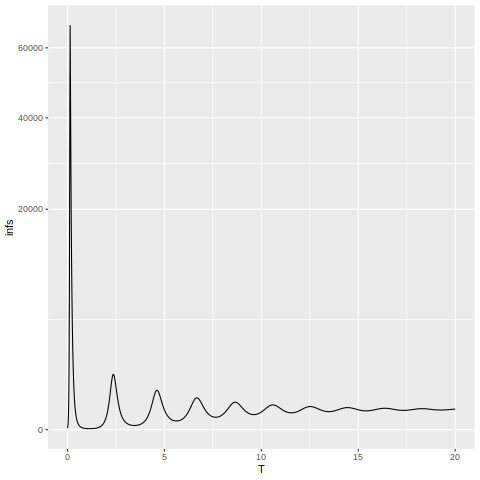

In [578]:
%%R -i MSIR_epi_res

MSIR_epi_res%>%
    filter(DisState=="I") %>%
    group_by(T)%>%
    summarize(infs=sum(N))%>%
    ungroup()%>%
    ggplot(aes(x=T,y=infs))+
        geom_line()+
        scale_y_sqrt()

**Some notes on this:**
- Many rules might need custom parsing so best build that in
- Likewise states probably need a way to specify categoricals for some 
  things to work.